In [60]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


import shap


import datetime
import time
import multiprocessing  as mp
from itertools import product

from keras.models import Sequential,Model
from keras.layers import *#Dense, Input, Concatenate, Lambda,LSTM,Dropout,Layer,Flatten
from keras.layers import ConvLSTM2D,BatchNormalization,TimeDistributed,MaxPooling3D
from keras.optimizers import RMSprop, Adam
from keras import optimizers
from keras.utils.vis_utils import plot_model
import keras.losses as kl
import pydot
from keras import backend as K
from keras import optimizers
import keras
import pickle
import tensorflow as tf
from keras.utils import multi_gpu_model
import sys
import warnings
import os
#from tqdm import tqdm
os.chdir('/gneven/Desktop/ETH/Sem2/Projeckt/Pyhton/')
from scipy.interpolate import UnivariateSpline
from functions import * 

idx = pd.IndexSlice

import keras.backend.tensorflow_backend as tfback

tf.config.threading.set_intra_op_parallelism_threads(7)
tf.config.threading.set_inter_op_parallelism_threads(7)

def _get_available_gpus():
    """Get a list of available gpu devices (formatted as strings).

    # Returns
        A list of available GPU devices.
    """
    #global _LOCAL_DEVICES
    if tfback._LOCAL_DEVICES is None:
        devices = tf.config.list_logical_devices()
        tfback._LOCAL_DEVICES = [x.name for x in devices]
    return [x for x in tfback._LOCAL_DEVICES if 'device:gpu' in x.lower()]

tfback._get_available_gpus = _get_available_gpus

(array([2.00000e+00, 1.00000e+00, 1.10000e+01, 2.80000e+01, 5.32101e+05,
        1.17208e+05, 5.65300e+03, 1.80000e+02, 1.40000e+01, 2.00000e+00]),
 array([-1677. , -1326.9,  -976.8,  -626.7,  -276.6,    73.5,   423.6,
          773.7,  1123.8,  1473.9,  1824. ], dtype=float32),
 <a list of 10 Patch objects>)

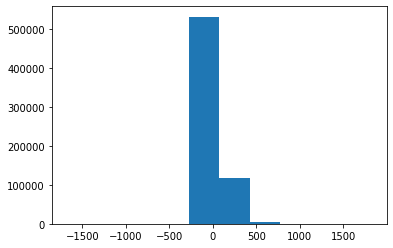

In [2]:
FrameT = pd.read_pickle(os.getcwd()+'/DataPickles/BusFrame32.pickle')
FrameT[np.isnan(FrameT)] = 0
# FrameT[FrameT>400] = 0
# FrameT[FrameT<-400] = 0
np.max(FrameT)

fig = plt.figure()

plt.hist(FrameT.ravel())

In [4]:
FrameT = pd.read_pickle(os.getcwd()+'/DataPickles/BusFrameT.pickle')

config = tf.compat.v1.ConfigProto(intra_op_parallelism_threads=6, 
                        inter_op_parallelism_threads=6, 
                        allow_soft_placement=True,
                        device_count = {'CPU': 6})

session = tf.compat.v1.Session(config=config)
tf.compat.v1.keras.backend.set_session(session)


FrameT[np.isnan(FrameT)] = 0
# FrameT[FrameT>400] = 0
# FrameT[FrameT<-400] = 0
FrameT = FrameT[:2,:,:,:,:]
meanF = np.mean(FrameT)
FrameT -= meanF
std = np.std(abs(FrameT))
FrameT /= std 

out_dt = 1
in_dt = 30
dt = 30

starttime = 7*3600
endtime = 9*3600

# 6.5 -- 10.5
in_data = [6.5*3600,10.5*3600]

diff = int((starttime- in_data[0])/dt)


input_bus = np.ndarray((FrameT.shape[0],int((endtime-out_dt-starttime)/dt),in_dt,FrameT.shape[2],FrameT.shape[3],FrameT.shape[4]))#FrameT.shape[2]
output_bus = np.ndarray((FrameT.shape[0],int((endtime-out_dt-starttime)/dt),out_dt,FrameT.shape[3],FrameT.shape[4]))
for i in range(int((endtime-out_dt-starttime)/dt)):
    input_bus[:,i,:,:,:,:] = FrameT[:,(diff+i-in_dt):(diff+i),:,:,:]
    output_bus[:,i,:,:,:] = FrameT[:,(diff+i):(diff+i+out_dt),2,:,:]
    
vali = input_bus#[[0,6,12,18,24,29,34],:,:,:,:]
valo = output_bus#[[0,6,12,18,24,29,34],:,:,:,:]
input_bus = np.delete(input_bus,[0,6,12,18,24,29,34], axis = 0)
output_bus = np.delete(output_bus,[0,6,12,18,24,29,34], axis = 0)

batch_size =input_bus.shape[1]
print(batch_size)

input_bus = input_bus.reshape(input_bus.shape[0]*input_bus.shape[1],input_bus.shape[2],input_bus.shape[3],input_bus.shape[4],input_bus.shape[5])
output_bus = output_bus.reshape(output_bus.shape[0]*output_bus.shape[1],output_bus.shape[2],output_bus.shape[3],output_bus.shape[4])

vali = vali.reshape(vali.shape[0]*vali.shape[1],vali.shape[2],vali.shape[3],vali.shape[4],vali.shape[5])
valo = valo.reshape(valo.shape[0]*valo.shape[1],valo.shape[2],valo.shape[3],valo.shape[4])

output_bus = np.expand_dims(output_bus,axis = 4)
valo = np.expand_dims(valo,axis = 4)


239


in the future out of bounds indices will raise an error instead of being ignored by `numpy.delete`.
in the future out of bounds indices will raise an error instead of being ignored by `numpy.delete`.


In [15]:
valo.shape


(478, 375)

In [15]:
filter1 = 64
filter2 = 32
kernel1 = 5
kernel2 = 5

epochs = 10
model = Sequential([
    BatchNormalization(name = 'batch_norm_0', input_shape = (in_dt,input_bus.shape[2],input_bus.shape[3],input_bus.shape[4])), 


    ConvLSTM2D(name ='conv_lstm_1',filters=filter1, kernel_size=(kernel1, 1),stateful=False
               , padding='same', return_sequences=True,data_format  ="channels_first"),
    Dropout(0.2),

    BatchNormalization(),

    ConvLSTM2D(name ='conv_lstm_2',filters=filter2, kernel_size=(kernel2, 1),stateful=False
               ,data_format  ="channels_first"
               ,padding='same', return_sequences=False),

    Dropout(0.2),

    BatchNormalization(),


    Flatten(),

    RepeatVector(out_dt),

    Reshape((out_dt,output_bus.shape[2],1,filter2)),


    ConvLSTM2D(name ='conv_lstm_3',filters=filter2,  kernel_size=(kernel2, 1),stateful=False
               , padding='same', return_sequences=True),
    Dropout(0.1),
    BatchNormalization(),

    ConvLSTM2D(name ='conv_lstm_4',
               filters = filter1, kernel_size = (kernel1, 1),stateful=False, 
               padding='same',
               return_sequences = True),
    #    Reshape((10,202472)) ,           
    #    
    #    TimeDistributed(Dense(out.shape[2]*20)),
    ##    
    #    TimeDistributed(Dense(32,)),
    #    
    TimeDistributed(Dense(1), name='test'),




])
# optimizer = optimizers.Adam(clipvalue=0.5)
#optimizer = optimizers.Adam(clipnorm=1.)
#     model = multi_gpu_model(model, gpus=6)
model.compile(loss='mean_squared_error', optimizer = 'adam',metrics=['accuracy'])
model.summary()

autoencoder_train = model.fit(input_bus, output_bus, epochs=30,
                              batch_size=batch_size, verbose=1, shuffle=False)


model1 = model
error = np.array([])


# for e in range(epochs):
#     errorp = 0
#     print('epoque :',e+1)
#     for day in range(FrameT.shape[0] -2):
#         model.fit(input_bus[day,:,:,:,:,:], output_bus[day,:,:,:,:,:], epochs=1,
#                   batch_size=batch_size, verbose=1, shuffle=False)
#         model.reset_states()
#         print('Day :',day+1,', epoch :', e+1)

#     for p in range(1,2):
#         predicty = model.predict(input_bus[-p,:,:,:,:,:])
#         errorp += np.sum(abs(predicty-output_bus[-p,:,:,:,:,:]))
            
#     print('Epoch',e,'Error:',errorp)
        
#     error = np.append(error,errorp)
            
      #,validation_data = (vali,valo)
 

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
batch_norm_0 (BatchNormaliza (None, 30, 3, 13, 1)      4         
_________________________________________________________________
conv_lstm_1 (ConvLSTM2D)     (None, 30, 64, 13, 1)     86016     
_________________________________________________________________
dropout_4 (Dropout)          (None, 30, 64, 13, 1)     0         
_________________________________________________________________
batch_normalization_4 (Batch (None, 30, 64, 13, 1)     4         
_________________________________________________________________
conv_lstm_2 (ConvLSTM2D)     (None, 32, 13, 1)         61568     
_________________________________________________________________
dropout_5 (Dropout)          (None, 32, 13, 1)         0         
_________________________________________________________________
batch_normalization_5 (Batch (None, 32, 13, 1)        

In [16]:
filter1 = 64
filter2 = 32
kernel1 = 5
kernel2 = 5
input_bus = input_bus[:,:,2:,:,:]

epochs = 10
model_1 = Sequential([
    BatchNormalization(name = 'batch_norm_0', input_shape = (in_dt,input_bus.shape[2],input_bus.shape[3],input_bus.shape[4])), 


    ConvLSTM2D(name ='conv_lstm_1',filters=filter1, kernel_size=(kernel1, 1),stateful=False
               , padding='same', return_sequences=True,data_format  ="channels_first"),
    Dropout(0.2),

    BatchNormalization(),

    ConvLSTM2D(name ='conv_lstm_2',filters=filter2, kernel_size=(kernel2, 1),stateful=False
               ,data_format  ="channels_first"
               ,padding='same', return_sequences=False),

    Dropout(0.2),

    BatchNormalization(),


    Flatten(),

    RepeatVector(out_dt),

    Reshape((out_dt,output_bus.shape[2],1,filter2)),


    ConvLSTM2D(name ='conv_lstm_3',filters=filter2,  kernel_size=(kernel2, 1),stateful=False
               , padding='same', return_sequences=True),
    Dropout(0.1),
    BatchNormalization(),

    ConvLSTM2D(name ='conv_lstm_4',
               filters = filter1, kernel_size = (kernel1, 1),stateful=False, 
               padding='same',
               return_sequences = True),
    #    Reshape((10,202472)) ,           
    #    
    #    TimeDistributed(Dense(out.shape[2]*20)),
    ##    
    #    TimeDistributed(Dense(32,)),
    #    
    TimeDistributed(Dense(1), name='test'),




])
# optimizer = optimizers.Adam(clipvalue=0.5)
#optimizer = optimizers.Adam(clipnorm=1.)
#     model = multi_gpu_model(model, gpus=6)
model_1.compile(loss='mean_squared_error', optimizer = 'adam',metrics=['accuracy'])
model_1.summary()

hist_1 = model_1.fit(input_bus, output_bus, epochs=30,
                              batch_size=batch_size, verbose=1, shuffle=False)




# for e in range(epochs):
#     errorp = 0
#     print('epoque :',e+1)
#     for day in range(FrameT.shape[0] -2):
#         model.fit(input_bus[day,:,:,:,:,:], output_bus[day,:,:,:,:,:], epochs=1,
#                   batch_size=batch_size, verbose=1, shuffle=False)
#         model.reset_states()
#         print('Day :',day+1,', epoch :', e+1)

#     for p in range(1,2):
#         predicty = model.predict(input_bus[-p,:,:,:,:,:])
#         errorp += np.sum(abs(predicty-output_bus[-p,:,:,:,:,:]))
            
#     print('Epoch',e,'Error:',errorp)
        
#     error = np.append(error,errorp)
            
      #,validation_data = (vali,valo)
 

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
batch_norm_0 (BatchNormaliza (None, 30, 1, 13, 1)      4         
_________________________________________________________________
conv_lstm_1 (ConvLSTM2D)     (None, 30, 64, 13, 1)     83456     
_________________________________________________________________
dropout_7 (Dropout)          (None, 30, 64, 13, 1)     0         
_________________________________________________________________
batch_normalization_7 (Batch (None, 30, 64, 13, 1)     4         
_________________________________________________________________
conv_lstm_2 (ConvLSTM2D)     (None, 32, 13, 1)         61568     
_________________________________________________________________
dropout_8 (Dropout)          (None, 32, 13, 1)         0         
_________________________________________________________________
batch_normalization_8 (Batch (None, 32, 13, 1)        

In [8]:
t1 = time.time()
predicty = list()
hist = list()
# for e in range(30):
#     hist.append(model.fit(input_bus, output_bus, epochs=1,
#                   batch_size=batch_size, verbose=1, shuffle=False)  )
    
# #     predicty.append(model.predict(vali[:239,:,:,:,:]))


    
#     print('epoch :' ,e, ' over' ) 


#     #
# print(time.time()-t1)

fig = plt.figure()
ax = fig.gca()

ax.plt()

Epoch 1/1
6692/6692 [==============================] - 232s 35ms/step - loss: 2.5456 - accuracy: 0.0000e+00
epoch : 0  over
Epoch 1/1
2390/6692 [=========>....................] - ETA: 2:18 - loss: 1.6973 - accuracy: 0.0000e+00

KeyboardInterrupt: 

In [16]:
t1 = time.time()

autoencoder_train = model.fit(input_bus, output_bus, epochs=30,
                  batch_size=batch_size, verbose=1, shuffle=False)
print(time.time()-t1)



RuntimeError: You must compile a model before training/testing. Use `model.compile(optimizer, loss)`.

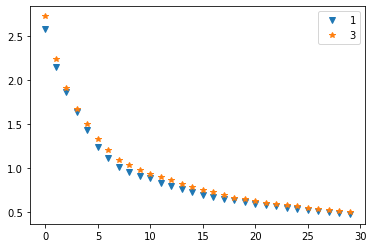

In [18]:
loss = autoencoder_train.history['loss']

fig = plt.figure(2)
ax = fig.gca()

ax.plot(hist_1.history['loss'],'v',label = '1')
            
ax.plot(loss,'*',label = '3')
plt.legend()

In [20]:
predict1 = model1.predict(vali[:239,:,:,:,:])
predict2 = model.predict(vali[:239,:,:,:,:])
which = 2


0.0


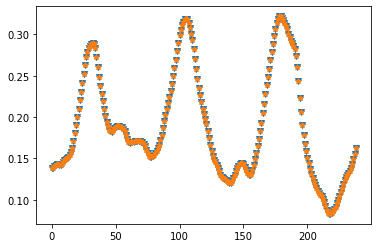

In [21]:
print(np.sum(abs(predict1-predict2)))
fig = plt.figure(3)
ax = fig.gca()
ax.plot(predict1[:,1,which,0,0],'v')
ax.plot(predict2[:,1,which,0,0],'*')


<IPython.core.display.Javascript object>


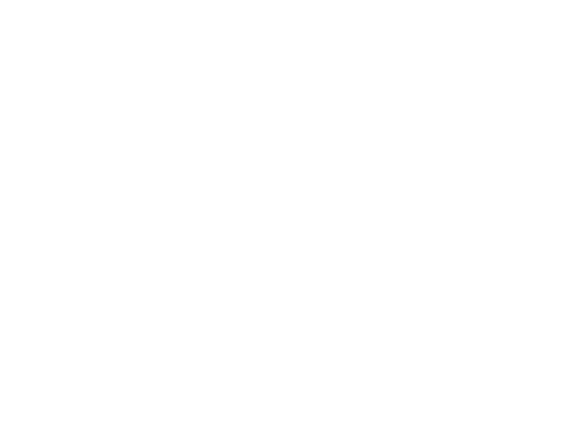

NameError: name 'predicty' is not defined

In [22]:
%matplotlib notebook
which = 1

fig = plt.figure(3)
ax1 = plt.subplot(3,1,1)
plt.title('Prediction')
ax2 = plt.subplot(3,1,2)
ax3 = plt.subplot(3,1,3)
plt.xlabel('Time from start (7am)[min]')
plt.ylabel('Lateness')
for i in range(0,len(predicty),10):
    ax1.plot(predicty[i][:,1,which,0,0],'*',label = 'Epoch %i' %i)
    ax2.plot(i,hist[i].history['loss'],'v')
    
ax3.plot(predicty[i][:,1,which,0,0]*10,'*',label = 'Epoch %i' %i)

ax3.plot(valo[:239,1,which,0,0])


In [ ]:
ax3.plot(predicty[i][:,1,which,0,0]*10,'*',label = 'Epoch %i' %i)

ax3.plot(valo[:239,1,which,0,0])

In [1]:
startTime = 7*3600
endTime = 10*3600
dt = 60

FrameT = np.load('BusFrame32.pickels')

x = np.asarray([*range(startTime,endTime,dt)])
y = FrameT[:,0,0,496]
w = np.isnan(y)
y[w] = 0.
spl = UnivariateSpline(x, y, w=~w)
%matplotlib notebook
for i in 50:
    spl.set_smoothing_factor(i)
    plt.plot(x, spl(x), lw=1,label = i)
    
plt.plot(x[~w], y[~w], 'r', ms=3)
plt.legend()

NameError: name 'np' is not defined

<IPython.core.display.Javascript object>


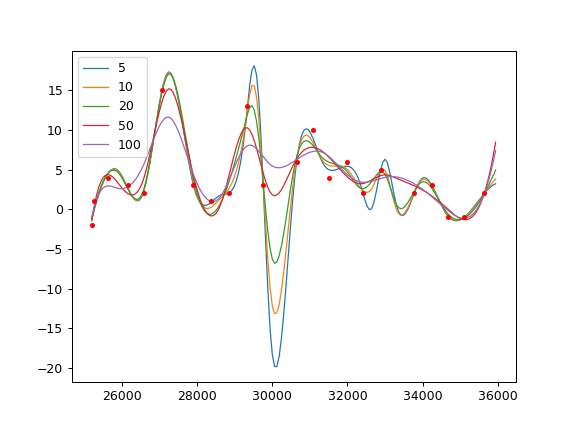

In [110]:

stops = get_stops_data()

In [4]:

allfile = os.listdir('data/data2/Times/')

Data = pd.read_csv('data/data2/Times/'+allfile[0])
Data['datum_nach'] = pd.to_datetime(Data['datum_nach'],format="%d.%m.%y")
Data = Data.loc[Data['datum_nach'].dt.dayofweek < 5,:]


(1102001, 34)

In [83]:
Data['kurs'] = 100*Data['linie'] + Data['kurs']
Data = Data[~Data['fw_lang'].str.contains('DEP|Einfahrt|Ausfahrt|GAR')]


# 281423


<IPython.core.display.Javascript object>


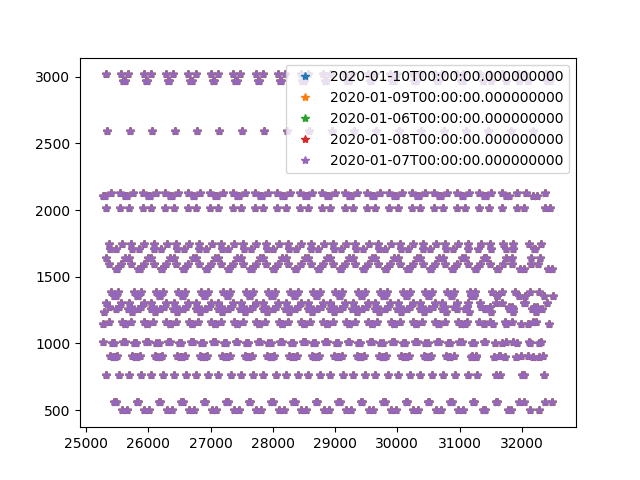

(980,)

(980,)

(980,)

(980,)

(980,)



,linie,richtung,betriebsdatum,fahrzeug,kurs,seq_von,halt_diva_von,halt_punkt_diva_von,halt_kurz_von1,datum_von,...,fahrweg_id,fw_no,fw_typ,fw_kurz,fw_lang,umlauf_von,halt_id_von,halt_id_nach,halt_punkt_id_von,halt_punkt_id_nach
386145,32,1,06.01.20,10452,3201,24,1307,10,IHAG,06.01.20,...,109988,1,1,1,HOLZ - STRV,215519,2807,2836,48161,46028
386663,32,1,06.01.20,10452,3201,24,1307,10,IHAG,06.01.20,...,109988,1,1,1,HOLZ - STRV,215519,2807,2836,48161,46028
389199,32,1,07.01.20,10075,3201,24,1307,10,IHAG,07.01.20,...,109988,1,1,1,HOLZ - STRV,215519,2807,2836,48161,46028
389832,32,1,07.01.20,10075,3201,24,1307,10,IHAG,07.01.20,...,109988,1,1,1,HOLZ - STRV,215519,2807,2836,48161,46028
392126,32,1,10.01.20,10093,3201,24,1307,10,IHAG,10.01.20,...,109988,1,1,1,HOLZ - STRV,214896,2807,2836,48161,46028
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1295732,32,2,09.01.20,10075,3201,22,1000,11,GLAU,09.01.20,...,115243,2,1,2,STRV - HOLZ,215519,2454,2457,44729,44335
1295872,32,2,08.01.20,10082,3201,22,1000,11,GLAU,08.01.20,...,115243,2,1,2,STRV - HOLZ,215519,2454,2457,44729,44335
1296234,32,2,08.01.20,10082,3201,22,1000,11,GLAU,08.01.20,...,115243,2,1,2,STRV - HOLZ,215519,2454,2457,44729,44335
1297238,32,2,08.01.20,10082,3201,9,1357,11,KALK,08.01.20,...,115243,2,1,2,STRV - HOLZ,215519,1906,2247,49953,42936


In [80]:
%matplotlib notebook

startTime = 7*3600
endTime = 9*3600
Data = Data[Data['linie'] == 32]
for day in Data['datum_nach'].unique():
    DataP = Data[Data['datum_nach'] == day]
    DataP = DataP[(DataP['soll_ab_von'] < endTime)&(DataP['soll_ab_von'] > startTime)]
    plt.plot(DataP['soll_ab_nach'],DataP['halt_diva_nach'],'*',label = day)
    print(DataP['soll_ab_nach'].shape)
    print()
    
    
plt.legend()  





Data[(Data['kurs'] == 3201 )& (Data['ist_ab_von'] < endTime)&(Data['ist_ab_von'] > startTime)]

In [38]:
service_kurs = set([])
DataO = Data[Data['datum_nach'] == Data['datum_nach'].unique()[-1]]
minO = np.inf
for  day in Data['datum_nach'].unique():
    if Data.loc[Data['datum_nach'] == day,'fw_lang'].unique().shape[0] < minO:
        DataO=Data[Data['datum_nach'] == day]   
    
    
for  day in Data['datum_nach'].unique():
    DataP = Data[(Data['datum_nach'] == day)]
    for kurs in DataP['kurs'].unique():
        Datapi = DataP[DataP['kurs'] == kurs]
        transVAr = Datapi.loc[~Datapi['soll_ab_nach'].isin(DataO.loc[DataO['kurs'] == kurs,'soll_ab_nach']),'fw_lang'].values
        for i in range(transVAr.shape[0]) :
            service_kurs.add(transVAr[i])
            


In [9]:
allfile = os.listdir('data/data2/Times/')



Data = get_time_data('data/data2/Times/'+allfile[0])

for str in allfile[1:]:
       Data = pd.concat([Data,get_time_data('data/data2/Times/'+str)])
    
Data = Data.loc[Data['datum_nach'].dt.dayofweek < 5,:]
#delete depot run
Data = Data[~Data['fw_lang'].str.contains('DEP|Einfahrt|Ausfahrt')]

Data['Lateness'] = (Data['ist_ab_nach']-Data['soll_ab_nach'])



there is  0.05199615380411645 % of lateness higher than 20min


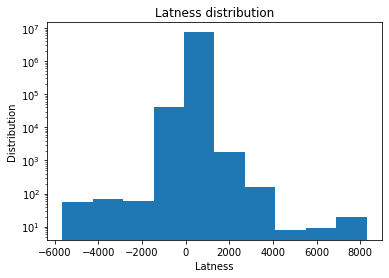

In [24]:
fig = plt.figure(10)

ax = fig.gca()

ax.hist(Data['Lateness'])
ax.set(xlabel = 'Latness',ylabel = 'Distribution',title = 'Latness distribution')
ax.set_yscale('log')

test = Data[Data['Lateness']> 1200]

print('there is ',Data[Data['Lateness']> 1200].shape[0]*100/Data.shape[0],'% of lateness higher than 20min')

29 janvier neige et 4 grosse pluie 17


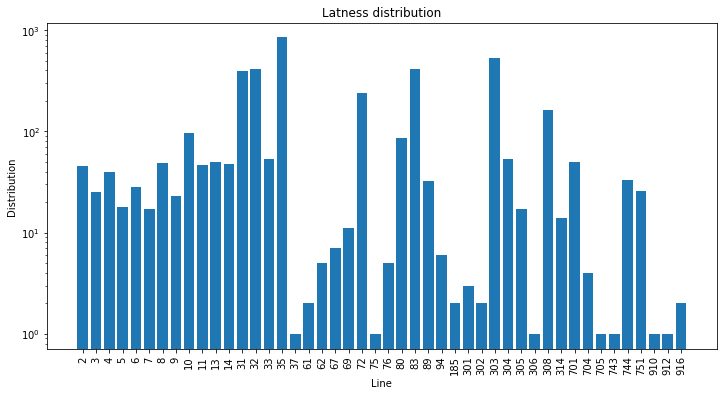

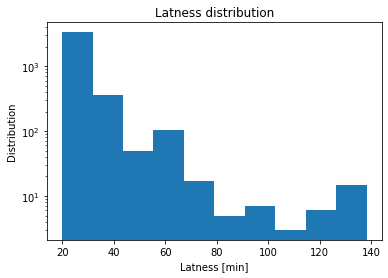

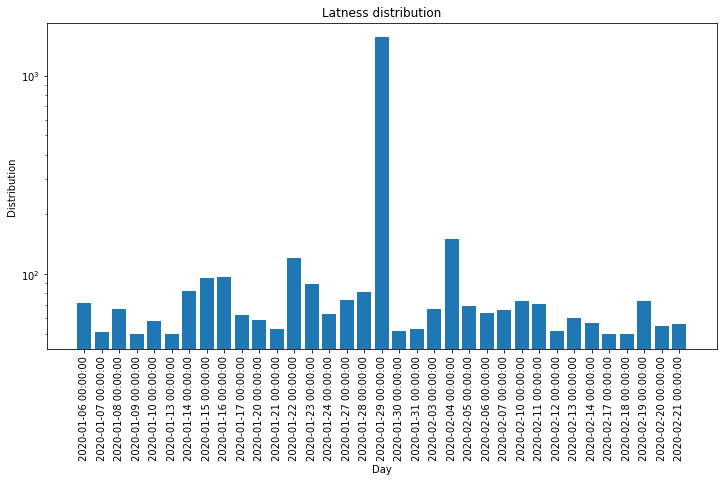

In [70]:
fig = plt.figure(11,figsize = (12,6))

ax = fig.gca()

ax.bar(range(len(test['linie'].unique())),test.groupby(['linie']).count()['richtung'])
ax.set(xlabel = 'Line',ylabel = 'Distribution',title = 'Latness distribution')
ax.set_yscale('log')

plt.xticks(range(len(test['linie'].unique())),rotation=90)
ax.set_xticklabels(test.groupby(['linie']).count().index)

fig = plt.figure(12)

ax = fig.gca()

ax.hist(test['Lateness']/60)
ax.set(xlabel = 'Latness [min]',ylabel = 'Distribution',title = 'Latness distribution')
ax.set_yscale('log')

fig = plt.figure(13,figsize = (12,6))

ax = fig.gca()

ax.bar(range(len(test['datum_nach'].unique())),test.groupby(['datum_nach']).count()['richtung'])
ax.set(xlabel = 'Day',ylabel = 'Distribution',title = 'Latness distribution')
ax.set_yscale('log')

plt.xticks(range(len(test['datum_nach'].unique())),rotation=90)
ax.set_xticklabels(test.groupby(['datum_nach']).count().index)

print('29 janvier neige et 4 grosse pluie 17')

[Text(0, 0, '2020-01-06 00:00:00'),
 Text(0, 0, '2020-01-07 00:00:00'),
 Text(0, 0, '2020-01-08 00:00:00'),
 Text(0, 0, '2020-01-09 00:00:00'),
 Text(0, 0, '2020-01-10 00:00:00'),
 Text(0, 0, '2020-01-13 00:00:00'),
 Text(0, 0, '2020-01-14 00:00:00'),
 Text(0, 0, '2020-01-15 00:00:00'),
 Text(0, 0, '2020-01-16 00:00:00'),
 Text(0, 0, '2020-01-17 00:00:00'),
 Text(0, 0, '2020-01-20 00:00:00'),
 Text(0, 0, '2020-01-21 00:00:00'),
 Text(0, 0, '2020-01-22 00:00:00'),
 Text(0, 0, '2020-01-23 00:00:00'),
 Text(0, 0, '2020-01-24 00:00:00'),
 Text(0, 0, '2020-01-27 00:00:00'),
 Text(0, 0, '2020-01-28 00:00:00'),
 Text(0, 0, '2020-01-30 00:00:00'),
 Text(0, 0, '2020-01-31 00:00:00'),
 Text(0, 0, '2020-02-03 00:00:00'),
 Text(0, 0, '2020-02-04 00:00:00'),
 Text(0, 0, '2020-02-05 00:00:00'),
 Text(0, 0, '2020-02-06 00:00:00'),
 Text(0, 0, '2020-02-07 00:00:00'),
 Text(0, 0, '2020-02-10 00:00:00'),
 Text(0, 0, '2020-02-11 00:00:00'),
 Text(0, 0, '2020-02-12 00:00:00'),
 Text(0, 0, '2020-02-13 00:0

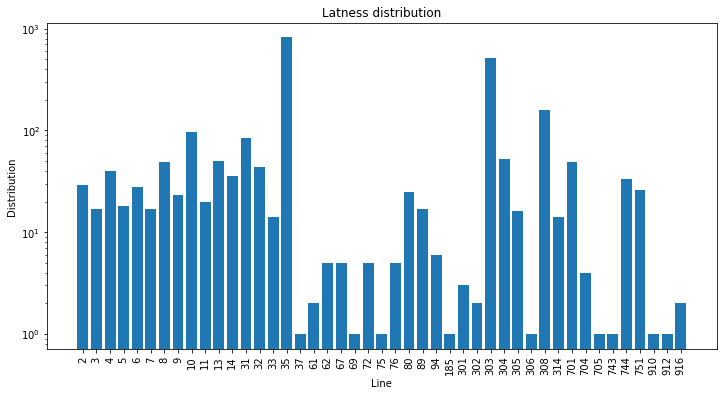

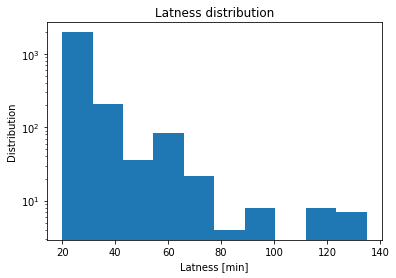

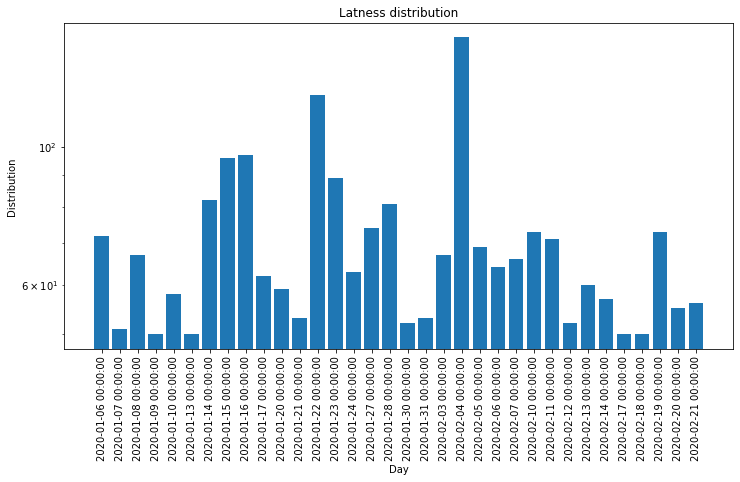

In [76]:
fig = plt.figure(14,figsize = (12,6))

test = test[~(test['datum_nach'] == test['datum_nach'].unique()[15])]

ax = fig.gca()

ax.bar(range(len(test['linie'].unique())),test.groupby(['linie']).count()['richtung'])
ax.set(xlabel = 'Line',ylabel = 'Distribution',title = 'Latness distribution')
ax.set_yscale('log')

plt.xticks(range(len(test['linie'].unique())),rotation=90)
ax.set_xticklabels(test.groupby(['linie']).count().index)

fig = plt.figure(15)

ax = fig.gca()

ax.hist(test['Lateness']/60)
ax.set(xlabel = 'Latness [min]',ylabel = 'Distribution',title = 'Latness distribution')
ax.set_yscale('log')

fig = plt.figure(16,figsize = (12,6))

ax = fig.gca()

ax.bar(range(len(test['datum_nach'].unique())),test.groupby(['datum_nach']).count()['richtung'])
ax.set(xlabel = 'Day',ylabel = 'Distribution',title = 'Latness distribution')
ax.set_yscale('log')

plt.xticks(range(len(test['datum_nach'].unique())),rotation=90)
ax.set_xticklabels(test.groupby(['datum_nach']).count().index)



In [33]:
with open('/gneven/ETH/Sem2/Projeckt/Pyhton/DataPickles/coor.pickle','rb') as pelo:
    Results = pickle.load(pelo)
    
with open('/gneven/ETH/Sem2/Projeckt/Pyhton/DataPickles/Data_line.pickle','rb') as f:
    line = pickle.load(f)
    
    

<IPython.core.display.Javascript object>


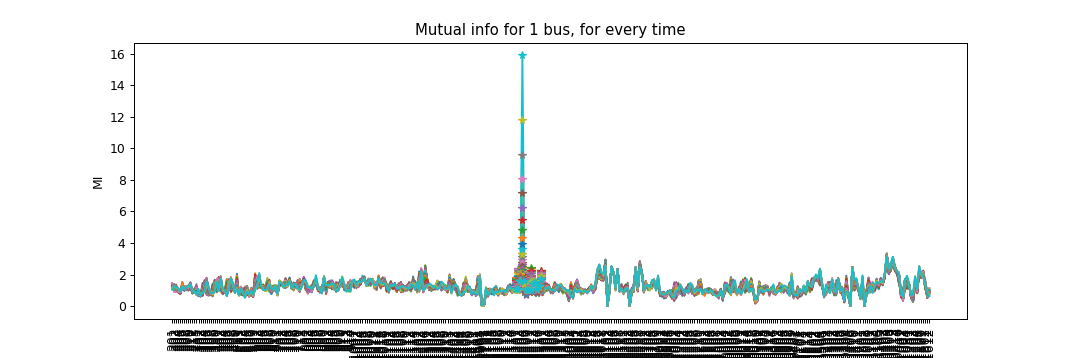

[Text(0, 0, '201'),
 Text(0, 0, '202'),
 Text(0, 0, '203'),
 Text(0, 0, '204'),
 Text(0, 0, '205'),
 Text(0, 0, '206'),
 Text(0, 0, '207'),
 Text(0, 0, '208'),
 Text(0, 0, '209'),
 Text(0, 0, '210'),
 Text(0, 0, '211'),
 Text(0, 0, '213'),
 Text(0, 0, '215'),
 Text(0, 0, '301'),
 Text(0, 0, '302'),
 Text(0, 0, '303'),
 Text(0, 0, '304'),
 Text(0, 0, '305'),
 Text(0, 0, '306'),
 Text(0, 0, '307'),
 Text(0, 0, '308'),
 Text(0, 0, '309'),
 Text(0, 0, '310'),
 Text(0, 0, '401'),
 Text(0, 0, '402'),
 Text(0, 0, '403'),
 Text(0, 0, '404'),
 Text(0, 0, '405'),
 Text(0, 0, '406'),
 Text(0, 0, '407'),
 Text(0, 0, '408'),
 Text(0, 0, '409'),
 Text(0, 0, '410'),
 Text(0, 0, '501'),
 Text(0, 0, '502'),
 Text(0, 0, '503'),
 Text(0, 0, '504'),
 Text(0, 0, '505'),
 Text(0, 0, '506'),
 Text(0, 0, '507'),
 Text(0, 0, '509'),
 Text(0, 0, '601'),
 Text(0, 0, '602'),
 Text(0, 0, '603'),
 Text(0, 0, '604'),
 Text(0, 0, '605'),
 Text(0, 0, '606'),
 Text(0, 0, '607'),
 Text(0, 0, '608'),
 Text(0, 0, '609'),


In [34]:
# Results_t0 = pd.DataFrame(Results[:,0,:],index = line[170:183])

%matplotlib notebook

fig = plt.figure(1,figsize = (12,4))

ax = fig.gca()

ax.plot(Results[3,:,:].T)
# ax.plot(range(line.shape[0]),Results[,1,:])
ax.plot(range(170,183),Results[3,:,170:183].T,'*')
ax.set(xlabel = 'Buses',ylabel = 'MI',title = 'Mutual info for 1 bus, for every time')
plt.xticks(range(line.shape[0]),rotation=90)
ax.set_xticklabels(line)


<IPython.core.display.Javascript object>


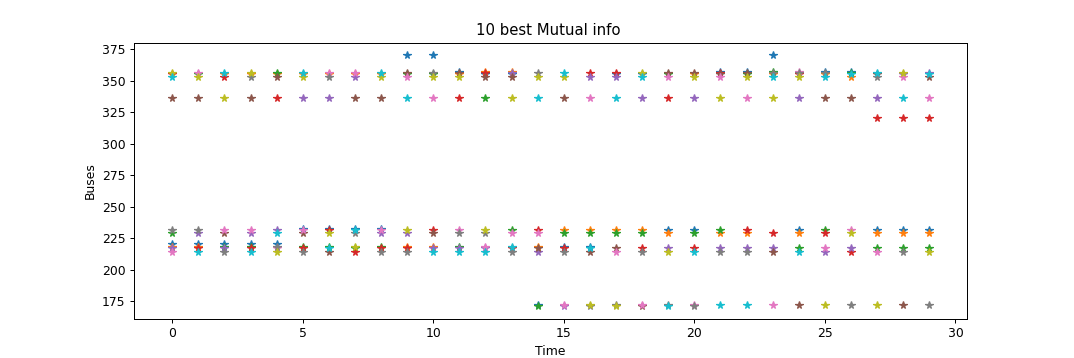

,Bus,Occ
20,704,1265
11,61,602
10,46,469
9,32,300
12,62,273
22,912,250
16,185,186
6,12,158
17,304,151
23,916,64


In [35]:
# np.idxmax(Results,axis = 0)
# numpy.where(Results == numpy.amax(arr))
N_max = 10
max_n = np.empty((13,30,N_max))
for b in range(Results.shape[0]):
    for t in range(Results.shape[1]):
        Results_i = Results[b,t,:]
        max_n[b,t,:] = np.argpartition(Results_i, -N_max)[-N_max:]

%matplotlib notebook

fig = plt.figure(2,figsize = (12,4))

ax = fig.gca()

# ax.plot(range(line.shape[0]),Results[,1,:])
ax.plot(max_n[2,:,:],'*')
ax.set(xlabel = 'Time',ylabel = 'Buses',title = '10 best Mutual info ')
# plt.xticks(range(line.shape[0]),rotation=90)
# ax.set_xticklabels(line)es


line_a = line[max_n.astype('int')].ravel()
line_a = np.floor(line_a/100).astype('int')
bins = np.bincount(line_a)
bin_o = []
for i in range(len(bins)):
    if bins[i] != 0:
#         print('Bus :',i,' ; ',bins[i])
        bin_o.append([i,bins[i]])
        
bin_o = pd.DataFrame(bin_o,columns = ['Bus','Occ'])
bin_o.sort_values('Occ',ascending = False)



# Backwards

In [26]:
# with open('/gneven/ETH/Sem2/Projeckt/Pyhton/DataPickles/step108_all.pickle','rb') as f:
#     predicty = pickle.load(f)
#     hist = pickle.load(f)
#     model = pickle.load(f)
with open('caseof.pickles','rb') as p:
    model_1 = pickle.load(p)
    hist_1 = pickle.load(p)
    
   
# model.summary()

EOFError: Ran out of input

In [28]:
filter1 = 64
filter2 = 32
kernel1 = 5
kernel2 = 5
input_bus = input_bus[:,:,2:,:,:]
out_dt = 1
epochs = 10

valo = np.squeeze(valo)
output_bus = np.squeeze(output_bus)
model_1 = Sequential([
    BatchNormalization(name = 'batch_norm_0', input_shape = (in_dt,input_bus.shape[2],input_bus.shape[3],input_bus.shape[4])), 


    ConvLSTM2D(name ='conv_lstm_1',filters=filter1, kernel_size=(kernel1, 1),stateful=False
               , padding='same', return_sequences=True,data_format  ="channels_first"),
    Dropout(0.2),

    BatchNormalization(),

    ConvLSTM2D(name ='conv_lstm_2',filters=filter2, kernel_size=(kernel2, 1),stateful=False
               ,data_format  ="channels_first"
               ,padding='same', return_sequences=False),

    Dropout(0.2),

    BatchNormalization(),


    Flatten(),

    RepeatVector(out_dt),

    Reshape((out_dt,375,1,filter2)),


    ConvLSTM2D(name ='conv_lstm_3',filters=filter2,  kernel_size=(kernel2, 1),stateful=False
               , padding='same', return_sequences=True),
    Dropout(0.1),
    BatchNormalization(),

    ConvLSTM2D(name ='conv_lstm_4',
               filters = filter1, kernel_size = (kernel1, 1),stateful=False, 
               padding='same',
               return_sequences = True),
    #    Reshape((10,202472)) ,           
    #    
    #    TimeDistributed(Dense(out.shape[2]*20)),
    ##    
    #    TimeDistributed(Dense(32,)),
    #    
    TimeDistributed(Dense(1), name='test'),

    Reshape((375,)),


])
# optimizer = optimizers.Adam(clipvalue=0.5)
#optimizer = optimizers.Adam(clipnorm=1.)
#     model = multi_gpu_model(model, gpus=6)
model_1.compile(loss=kl.mean_absolute_error, optimizer = 'adam',metrics=['accuracy'])
model_1.summary()

hist_1 = model_1.fit(input_bus, output_bus, epochs=30,
                              batch_size=batch_size, verbose=1, shuffle=False)

with open('caseof.pickles','rb') as p:
    model = pickle.load(model_1,p)
    hist = pickle.load(hist_1,p)
    


NameError: name 'input_bus' is not defined

In [2]:
with open('caseof.pickles','rb') as p:
    model = pickle.load(p)
    hist = pickle.load(p)

In [5]:
model.summary()
print(vali.shape)
explainer = shap.DeepExplainer(model, tf.convert_to_tensor(vali[:239,:,2:3,:,:],dtype = 'float32'))


Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
batch_norm_0 (BatchNormaliza (None, 30, 1, 375, 1)     4         
_________________________________________________________________
conv_lstm_1 (ConvLSTM2D)     (None, 30, 64, 375, 1)    83456     
_________________________________________________________________
dropout_1 (Dropout)          (None, 30, 64, 375, 1)    0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 30, 64, 375, 1)    4         
_________________________________________________________________
conv_lstm_2 (ConvLSTM2D)     (None, 32, 375, 1)        61568     
_________________________________________________________________
dropout_2 (Dropout)          (None, 32, 375, 1)        0         
_________________________________________________________________
batch_normalization_2 (Batch (None, 32, 375, 1)       

keras is no longer supported, please use tf.keras instead.


In [18]:
# explainer
# shap_values = explainer.shap_values(tf.convert_to_tensor(vali[:10,:,2:3,:,0:],dtype = 'float32'))

# shap_values_0 = explainer.shap_values(tf.convert_to_tensor(valo[:239,:],dtype = 'float32'))
# hidden_layers1 = keras.backend.function([model.layers[0].input],[model.layers[1].output]) 
# hidden_layers2 = keras.backend.function([model.layers[0].input],[model.layers[4].output]) 
# hidden_layers3 = keras.backend.function([model.layers[0].input],[model.layers[9].output]) 
# hidden_layers4 = keras.backend.function([model.layers[0].input],[model.layers[12].output]) 


# LSTM1 = np.asarray(hidden_layers1([vali[:239,:,2:3,:,:]]))
# LSTM2 = np.asarray(hidden_layers2([vali[:239,:,2:3,:,:]]))
# LSTM3 = np.asarray(hidden_layers3([vali[:239,:,2:3,:,:]]))
# LSTM4 = np.asarray(hidden_layers4([vali[:239,:,2:3,:,:]]))


hidden_layers1_in = keras.backend.function([model.layers[0].input],[model.layers[0].output]) 
hidden_layers2_in = keras.backend.function([model.layers[0].input],[model.layers[3].output]) 
hidden_layers3_in = keras.backend.function([model.layers[0].input],[model.layers[8].output]) 
hidden_layers4_in = keras.backend.function([model.layers[0].input],[model.layers[11].output]) 


LSTM1_in = np.asarray(hidden_layers1_in([vali[:239,:,2:3,:,:]]))
LSTM2_in = np.asarray(hidden_layers2_in([vali[:239,:,2:3,:,:]]))
LSTM3_in = np.asarray(hidden_layers3_in([vali[:239,:,2:3,:,:]]))
LSTM4_in = np.asarray(hidden_layers4_in([vali[:239,:,2:3,:,:]]))

In [70]:
LSTM1_in.shape
LSTM1[0,0,:,:,:30,0].ravel().shape

(57600,)

In [ ]:
# def ANN(shapeIN,shapeOut):
ANN = Sequential([Flatten(input_shape = LSTM1_in.shape[2:]),
            Dense(57600),
#         Reshape(shapeOut),

    ])

ANN.summary()

In [62]:
model1 = ANN(LSTM1_in.shape,LSTM1.shape)
model1.summary()

ResourceExhaustedError: OOM when allocating tensor with shape[11250,720000] and type float on /job:localhost/replica:0/task:0/device:CPU:0 by allocator mklcpu [Op:RandomUniform]